# This notebook processes plasma state profile obtained with 2D SolEdge code


In [1]:
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm
import numpy as np


# import numpy as np
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# from colorspacious import cspace_converter

# plotter for data (x,z) and response surface function(*x)
#   - initalize with x and z (and function)
#   - interpolate if function is not provided
#   - can downsample
#   - plot data and response surface
# """

# class SolEdgePlotter:

In [2]:
# !pip install matplotlib

In [3]:
# !pip install h5py

In [4]:
# %cd /Users/42d/WEST/SOLEDGEx

In [5]:
iphi = -1

In [6]:
def refParams(refFileName):
    # reference parameters
    ref=h5py.File(refFileName,'r')
    n0=ref['/n0'][...]
    T0=ref['/T0'][...]
    c0=ref['/c0'][...]
    W0=ref['/W0'][...]
    rho0=ref['/rho0'][...]
    R0=ref['/R0'][...]
    a0=ref['/a0'][...]
   
    
    
    
    ref.close()
    
    return n0, T0, c0, W0, rho0,R0, a0 

def Convert2RealUnits(field, refFileName):
    
    # reference parameters
    n0, T0, c0, W0, rho0,R0, a0 = refParams(refFileName)
    
    if(field[-2:]=='/n'):
        X0 = n0
    elif(field[-2:]=='/T'):
        X0 = T0
    elif(field[-2:]=='/G'):   # parallel velocity
        X0 = n0*c0
    elif(field[-2:]=='/v'):
        X0 = c0
    elif(field[-2:]=='HI'):
        X0 = T0
    elif(field[-2:]=='/W'):
        X0 = W0
    elif(field[-2:]=='Ee'):
        X0 = n0*T0*1.6e-19
    elif(field[-2:]=='Ei'):
        X0 = n0*T0*1.6e-19
    else:
        X0 = 1
        
    return X0

# def PlotLabel():



In [7]:

def getWallInfo(meshFileName, refFileName):
    
    # reference parameters
    n0, T0, c0, W0, rho0,R0, a0 = refParams(refFileName)
    print('n0', n0)
    # wall and psi
    mesh=h5py.File(meshFileName,'r')
    # meshEIRENE=h5py.File('meshEIRENE.h5','r')
    Rwall=mesh['/wall/R'][...]
    Zwall=mesh['/wall/Z'][...]
    r2D=mesh['/config/r'][...]
    print('r2D',r2D.shape)
    z2D=mesh['/config/z'][...]
    psi2D=mesh['/config/psi'][...]
    psisep=mesh['/config/psisep1'][...]
    #rescale
    R0init=mesh['/R0'][...]
    a0init=mesh['/a0'][...]
    Rwall = (Rwall-R0init)/a0init*a0+R0
    Zwall = (Zwall)/a0init*a0
    r2D = (r2D-R0init)/a0init*a0+R0
    z2D = (z2D)/a0init*a0

    # restrict to points within wall limits
    S=np.shape(r2D)
    for i in range(0,S[0]):
        if(r2D[i,0]>np.min(Rwall)):
            break
    iRmin=i
    for i in range(0,S[0]):
        if(r2D[i,0]>np.max(Rwall)):
            break
    iRmax=i
    for i in range(0,S[1]):
        if(z2D[0,i]>np.min(Zwall)):
            break
    iZmin=i
    for i in range(0,S[0]):
        if(z2D[0,i]>np.max(Zwall)):
            break
    iZmax=i
#     r2D=r2D[iRmin:iRmax,iZmin:iZmax]
#     z2D=z2D[iRmin:iRmax,iZmin:iZmax]
#     psi2D=psi2D[iRmin:iRmax,iZmin:iZmax]
    mesh.close()
    
    return Rwall, Zwall, r2D, z2D, psi2D,psisep


In [8]:
data=h5py.File("refParam_raptorX.h5", "r")

In [9]:
%ls

InterpolationPlasmaProfiles.ipynb  metric_raptorX.h5
ProcessGitrOutput.ipynb*           plasma_1p5MW.h5
ProcessingSolEdgeData.ipynb        plot_positions.m*
data.txt                           readSoledgeData.asv
mesh.h5                            readSoledgeData.m
meshEIRENE.h5                      refParam_raptorX.h5
mesh_raptorX.h5                    remesh_for_cherab_atul.py


In [10]:
data=h5py.File("mesh.h5", "r")

In [11]:
data.keys()

<KeysViewHDF5 ['B0', 'NZones', 'R0', 'a0', 'config', 'neighbors', 'wall', 'zone1', 'zone10', 'zone11', 'zone12', 'zone13', 'zone14', 'zone15', 'zone16', 'zone2', 'zone3', 'zone4', 'zone5', 'zone6', 'zone7', 'zone8', 'zone9']>

In [12]:
data=h5py.File("plasma_1p5MW.h5", "r")

In [13]:
data['triangles'].keys()

<KeysViewHDF5 ['Nspec0', 'Nspec1', 'Nspec2', 'spec0', 'spec1', 'spec2', 'spec3', 'spec4', 'spec5', 'spec6', 'spec7', 'spec8', 'spec9']>

In [14]:
data=h5py.File("refParam_raptorX.h5", "r")

In [15]:
data.keys()

<KeysViewHDF5 ['B0', 'R0', 'T0', 'W0', 'a0', 'c0', 'n0', 'phi0', 'rho0', 'tau0']>

In [16]:

def getFieldData(field,refFileName,plasmaStateFile,mesh_raptorXFile,fluctuations):
#     fluctuations=0,1,2


    mesh_raptorX=h5py.File(mesh_raptorXFile,'r')
    Nzones = int(mesh_raptorX['/NZones'][...])
    
    data=h5py.File(plasmaStateFile,'r')
    
    X = data['/triangles'+field][...]
    X0= Convert2RealUnits(field, refFileName)
    print('X', X.shape)
    if(fluctuations==1):
        X = X[iphi+1,:] - np.mean(X[:,:],0)
    elif(fluctuations==2):
        X = np.mean(X[:,:],0)
    else:
        X = X[iphi+1,:]
        
    return X*X0, X0


In [17]:
def Plot(field,refFileName,meshFileName, plasmaStateFile,
         mesh_raptorXFile,fluctuations,meshEIRENEFile, plot=False):
    
    X, X0=getFieldData(field,refFileName,plasmaStateFile,mesh_raptorXFile,fluctuations)
    # colorstyle
    colormap = 'jet'
    #plt.style.use('dark_background')
#     colormap = 'twilight'

    fluctuations = 0 #0 : pp plane, 1: fluctuations, 2: phi average
    logplot = False
    logplotdecades = 3
    # get min max 
    Xmin=1e100
    Xmax=-1e100

    # tune colorbar range (auto if cmin=cmax)
    cmin=0
    cmax=0
    
    meshEIRENE=h5py.File(meshEIRENEFile,'r')
    
    Xmin=min(Xmin,np.min(X))
    Xmax=max(Xmax,np.max(X))

    if(cmin==cmax):
        if(fluctuations==1):
            cmin=min(Xmin,-Xmax)
            cmax=max(Xmax,-Xmin)
        else:
            cmin=Xmin
            cmax=Xmax
        cmin = cmin #*X0
        cmax = cmax #*X0
        if(logplot):
            cmax = int(np.log10(cmax))+1
            cmin = cmax - logplotdecades
    if plot:        
        fig = plt.figure(figsize=(6,6))
        sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=cmin, vmax=cmax))
        # sm = plt.cm.ScalarMappable(cmap=colormap, norm=colors.LogNorm(vmin=cmin, vmax=cmax))
        # plot
        triKnots = meshEIRENE['/triangles/tri_knots'][...]
        Rk = meshEIRENE['/knots/R'][...]
        Zk = meshEIRENE['/knots/Z'][...]


        levels=np.arange(cmin,cmax,(cmax-cmin)/50)
        levels=np.append(levels,cmax*2)
        tri1=plt.tripcolor(Rk/100, Zk/100, triKnots.T-1,
                           facecolors=X,
                           cmap=colormap,vmin=cmin,vmax=cmax)


        cbar = plt.colorbar(sm)
        Rwall, Zwall, r2D, z2D, psi2D,psisep=  getWallInfo(meshFileName, refFileName)

        plt.plot(Rwall,Zwall,'-')
#         plt.xlim([1.6381837946150934,3.333122375571507])
#         plt.ylim([-1.1282651547999007,1.201192235459778])
#         r=np.linspace(1.6381837946150934,3.333122375571507,146)
# z=np.linspace(-1.1282651547999007,1.201192235459778,165)
        plt.contour(r2D,z2D,psi2D,levels=[psisep[0]])
        plt.axis('scaled')
        
        spec=float(field[5:6]) 
        if spec == 0.0:
             species = 'electron'
        elif spec == 1.0:
            species = 'D'
        elif spec == 2.0:
            species = 'O'
        elif spec == 3.0:
            species = '$0^{+}$'
        elif spec == 4.0:
            species = '$0^{2+}$'
        elif spec == 5.0:
            species = '$0^{3+}$'
        elif spec == 6.0:
            species = '$0^{4+}$'   
        elif spec == 7.0:
            species = '$0^{5+}$'
        elif spec == 8.0:
            species = '$0^{6+}$'
        elif spec == 9.0:
            species = '$0^{7+}$'
        else:
            print('Element does not exist in the plasma file!')

        plt.title(species)


        plt.xlim([np.min(Rwall),np.max(Rwall)])
        plt.ylim([np.min(Zwall),np.max(Zwall)])

        plt.xlabel(r'$R$ [m]')
        plt.ylabel(r'$Z$ [m]')

        if(field[-1:]=='n'):
            cbar.set_label(str(field[-1:])+' [$m^{-3}$]')
        elif(field[-1:]=='T'):
            cbar.set_label(str(field[-1:])+' [eV]')
        elif(field[-1:]=='G'):   # parallel velocity
            cbar.set_label(str(field[-1:])+' [$m^{-2}$/s]')
        elif(field[-1:]=='v'):
             cbar.set_label(str(field[-1:])+' [m/s]')
        elif(field[-1:]=='Ee'):
             cbar.set_label(str(field[-1:])+' [Pa]')
        elif(field[-1:]=='Ei'):
            cbar.set_label(str(field[-1:])+' [Pa]')
        else:
            print('Unknown field')

#         plt.axis('scaled')

        #plt.savefig('PlasmaTri.png',dpi=600)
        plt.show()
    
    return X


# Let us now take a closer look at SolEdge data

In [18]:
###  The file contains electron, deuterium, O (Z=0,7) - overall 10 species.

n_species=10
Species_names = [f"/spec{i}/" for i in range(n_species)]
Fields_names = ["G", "n", "T"]   # G is current density [m2/s], n density [1/m3], and T temperature [eV]

In [19]:
### Loading SolEdge files
mesh_raptorXFile='mesh_raptorX.h5'
meshFileName='mesh.h5'
refFileName='refParam_raptorX.h5'
meshEIRENEFile='meshEIRENE.h5'
plasmaStateFile = 'plasma_1p5MW.h5'
fluctuations=0

In [20]:
meshEIRENE=h5py.File('meshEIRENE.h5','r')
mesh=h5py.File('mesh.h5','r')

Rk = meshEIRENE['/knots/R'][...]
Zk = meshEIRENE['/knots/Z'][...]
triKnots = meshEIRENE['/triangles/tri_knots'][...]


    
# a = np.array(Zk);
# data1=np.transpose(a)


# for i in data1:
#    print(i ,end = ' ')
    
# b = np.array(Rk/100)
# data1=np.transpose(b)

# for i in data1:
#     print(i ,end = ' ')

In [21]:
mesh.keys()
data = h5py.File('mesh_raptorX.h5','r')
Bphi=data['triangles']['Bphi'][:]
Br=data['triangles']['Br'][:]
Bz=data['triangles']['Bz'][:]




n0 [1.e+19]
r2D (300, 300)


Text(0, 0.5, '$Z$ [m]')

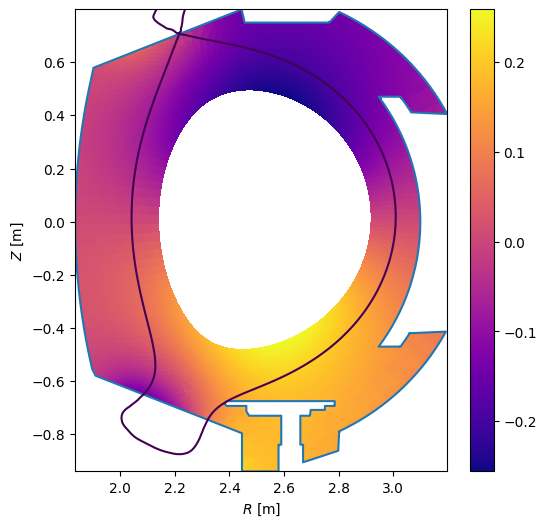

In [22]:
data = h5py.File('mesh_raptorX.h5','r')
data1 = h5py.File("refParam_raptorX.h5", "r")
B0=data1['B0'][...]
n0=data1['n0'][...]
Bphi=data['triangles']['Bphi'][:]*B0
Br=data['triangles']['Br'][:]*B0
Bz=data['triangles']['Bz'][:]*B0

X = Br

# colorstyle

# colormap ='jet'
# plt.style.use('dark_background')
# colormap = 'twilight_shifted'
colormap = 'plasma'

fluctuations = 0 #0 : pp plane, 1: fluctuations, 2: phi average
logplot = False
logplotdecades = 3
# get min max 
Xmin=1e100
Xmax=-1e100

# tune colorbar range (auto if cmin=cmax)
cmin=0
cmax=0

meshEIRENE=h5py.File(meshEIRENEFile,'r')

Xmin=min(Xmin,np.min(X))
Xmax=max(Xmax,np.max(X))

if(cmin==cmax):
    if(fluctuations==1):
        cmin=min(Xmin,-Xmax)
        cmax=max(Xmax,-Xmin)
    else:
        cmin=Xmin
        cmax=Xmax
    cmin = cmin #*X0
    cmax = cmax #*X0
    if(logplot):
        cmax = int(np.log10(cmax))+1
        cmin = cmax - logplotdecades

       
       
fig = plt.figure(figsize=(6,6))
# sm = plt.cm.ScalarMappable(cmap=colormap, norm=colors.LogNorm(vmin=cmin, vmax=cmax))
sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=cmin, vmax=cmax))
# plot
triKnots = meshEIRENE['/triangles/tri_knots'][...]
Rk = meshEIRENE['/knots/R'][...]
Zk = meshEIRENE['/knots/Z'][...]


levels=np.arange(cmin,cmax,(cmax-cmin)/50)
levels=np.append(levels,cmax*2)
tri1=plt.tripcolor(Rk/100, Zk/100, triKnots.T-1,
                   facecolors=X,
                   cmap=colormap,vmin=cmin,vmax=cmax)

cbar = plt.colorbar()
Rwall, Zwall, r2D, z2D, psi2D,psisep=  getWallInfo(meshFileName, refFileName)

plt.plot(Rwall,Zwall,'-')
plt.contour(r2D,z2D,psi2D,levels=[psisep[0]])
# plt.xlim(1.8,3.25)
# plt.ylim(-0.9,0.9)
plt.xlim([np.min(Rwall),np.max(Rwall)])
plt.ylim([np.min(Zwall),np.max(Zwall)])
plt.xlabel(r'$R$ [m]')
plt.ylabel(r'$Z$ [m]')
# plt.clim(1E18,5E20)
# plt.axis('scaled')
# plt.tight_layout(h_pad=1)


        
        


In [23]:
min(n0)

1e+19

In [24]:
data = h5py.File(plasmaStateFile,'r')
data['/triangles'].keys()
data['/triangles/spec0'].keys()

<KeysViewHDF5 ['G', 'RadiatedPower', 'T', 'VacuumFlag', 'n']>

In [25]:
data = h5py.File(mesh_raptorXFile,'r')
data['/zone1'].keys()
# Rc=data['/zone1/Rcorners'][...]


<KeysViewHDF5 ['B', 'Bphi', 'Br', 'BufferMask', 'Bz', 'Nphi', 'Npsi', 'Ntheta', 'Rcells', 'Rcorners', 'Zcells', 'Zcorners', 'chi', 'chiCore', 'phicells', 'phicorners', 'psi']>

X (1, 30410)


/var/folders/jc/f0qzb85j0p102grvg_s4spsm5jr2zx/T/ipykernel_9319/1438712959.py:55: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


n0 [1.e+19]
r2D (300, 300)


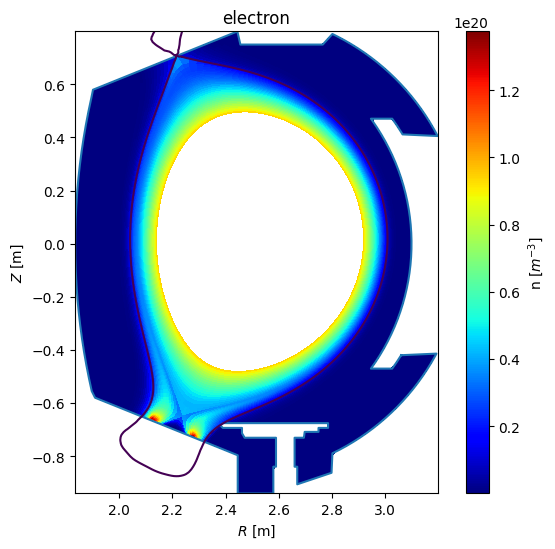

In [26]:
var='/spec0/n'
n=Plot(var,refFileName,meshFileName,
             plasmaStateFile,mesh_raptorXFile,
             fluctuations,meshEIRENEFile, plot='on')

In [27]:
Fields_names

['G', 'n', 'T']

In [28]:
var='/spec0/G'
ve=Plot(var,refFileName,meshFileName,
             plasmaStateFile,mesh_raptorXFile,
             fluctuations,meshEIRENEFile)
var='/spec0/n'
ne=Plot(var,refFileName,meshFileName,
             plasmaStateFile,mesh_raptorXFile,
             fluctuations,meshEIRENEFile)
var='/spec0/T'
te=Plot(var,refFileName,meshFileName,
             plasmaStateFile,mesh_raptorXFile,
             fluctuations,meshEIRENEFile)


var='/spec1/G'
vi=Plot(var,refFileName,meshFileName,
             plasmaStateFile,mesh_raptorXFile,
             fluctuations,meshEIRENEFile)
var='/spec0/n'
ni=Plot(var,refFileName,meshFileName,
             plasmaStateFile,mesh_raptorXFile,
             fluctuations,meshEIRENEFile)
var='/spec0/T'
ti=Plot(var,refFileName,meshFileName,
             plasmaStateFile,mesh_raptorXFile,
             fluctuations,meshEIRENEFile)


X (1, 30410)
X (1, 30410)
X (1, 30410)
X (1, 30410)
X (1, 30410)
X (1, 30410)


In [29]:
N=triKnots.T-1

X (1, 30410)


/var/folders/jc/f0qzb85j0p102grvg_s4spsm5jr2zx/T/ipykernel_9319/1438712959.py:55: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


n0 [1.e+19]
r2D (300, 300)


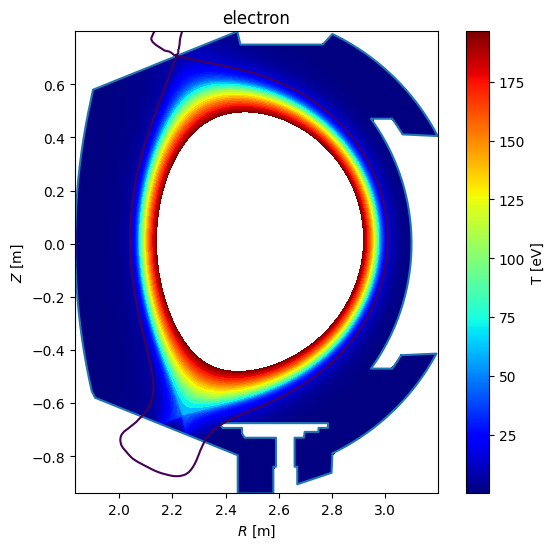

In [30]:

ti=Plot(var,refFileName,meshFileName,
             plasmaStateFile,mesh_raptorXFile,
             fluctuations,meshEIRENEFile,plot=True)





In [31]:
import csv

my_output = open('data.txt', 'w')
# mywriter = csv.writer(my_output)

data = h5py.File('mesh_raptorX.h5','r')
data1 = h5py.File("refParam_raptorX.h5", "r")
B0=data1['B0'][...]
bphi=data['triangles']['Bphi'][:]*B0
br=data['triangles']['Br'][:]*B0
bz=data['triangles']['Bz'][:]*B0

# R = np.transpose(np.array(Rk/100))
# Z = np.transpose(np.array(Zk/100))
r =[Rk[i]/100 for i in triKnots[0]-1]
z =[Zk[i]/100 for i in triKnots[0]-1]

R = np.array(r)
Z = np.array(z)

len(R)


ne = np.array(ne)
ve = (np.array(ve))/ne
te = np.array(te)


ni = np.array(ni)
vi = (np.array(vi))/ni
ti = (np.array(ti))

data=[R,Z,bphi, br, bz, ve,ne,te,vi,ni,ti]
csv_writer = csv.writer(my_output,delimiter=' ', quoting=csv.QUOTE_NONE,quotechar="'",doublequote=True)
csv_writer = csv.writer(my_output,delimiter=' ')
my_output.write('#R Z bphi br bz ve,ne,te,vi,ni,ti')
csv_writer.writerow('')



for i in range(len(data[0])):
    
    row = [data[j][i] for j in range(len(data))]
    csv_writer.writerow(row)

my_output.close()


In [32]:
len(R)

30410

In [33]:
# bz=data['triangles']['Bz'][:]
# bz.shape

X (1, 30410)


/var/folders/jc/f0qzb85j0p102grvg_s4spsm5jr2zx/T/ipykernel_9319/1438712959.py:55: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


n0 [1.e+19]
r2D (300, 300)


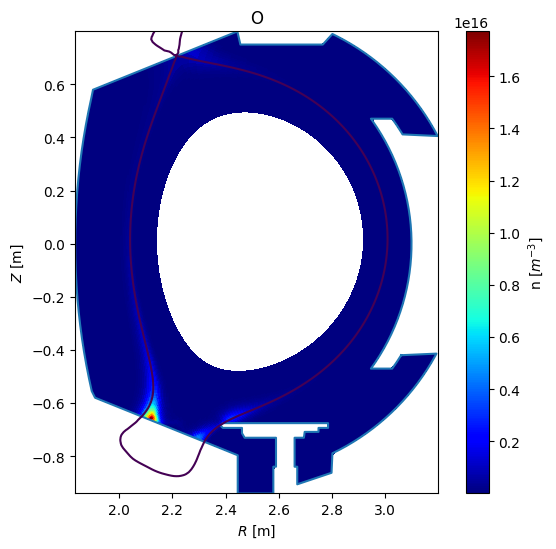

X (1, 30410)
n0 [1.e+19]
r2D (300, 300)


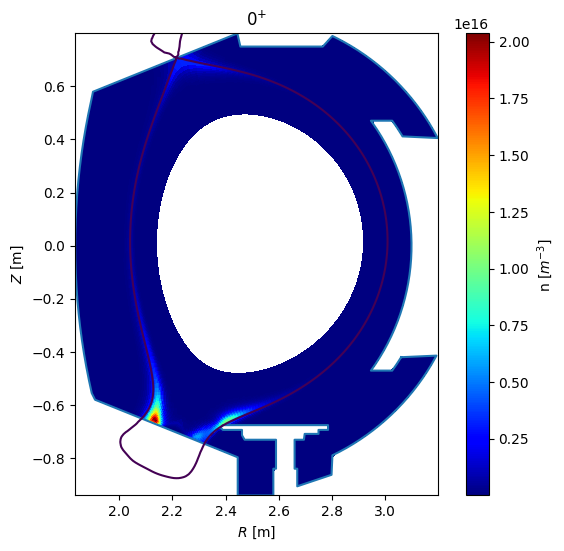

X (1, 30410)
n0 [1.e+19]
r2D (300, 300)


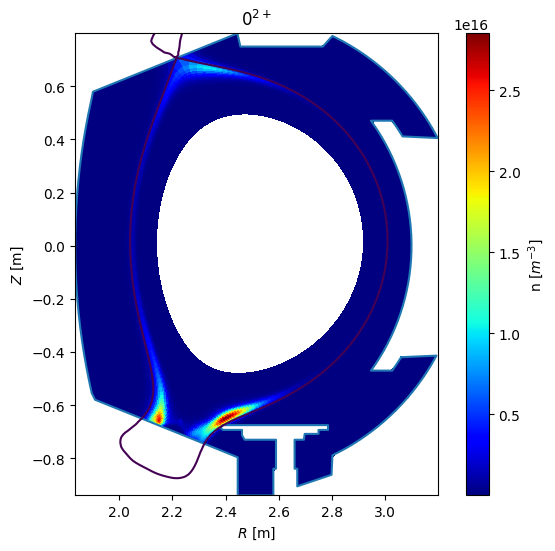

X (1, 30410)
n0 [1.e+19]
r2D (300, 300)


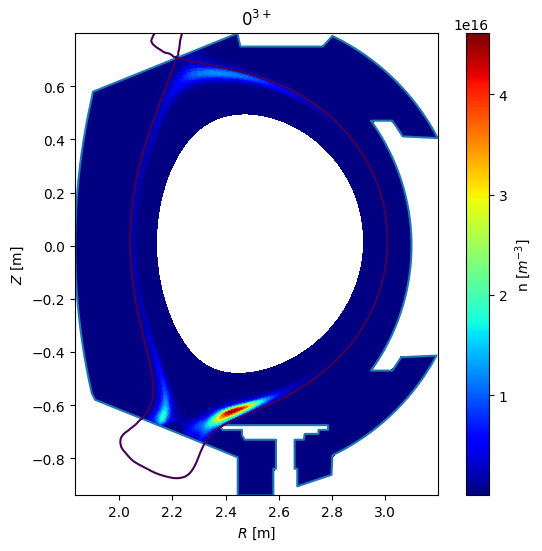

X (1, 30410)
n0 [1.e+19]
r2D (300, 300)


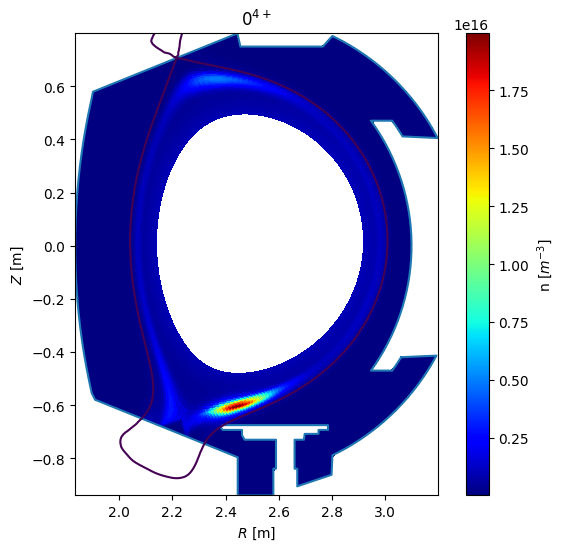

X (1, 30410)
n0 [1.e+19]
r2D (300, 300)


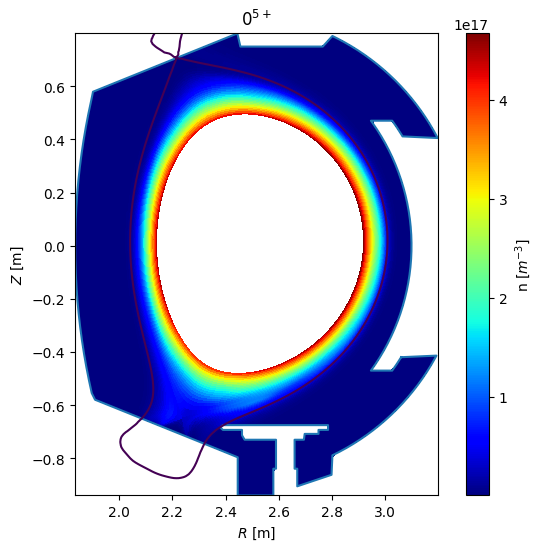

X (1, 30410)
n0 [1.e+19]
r2D (300, 300)


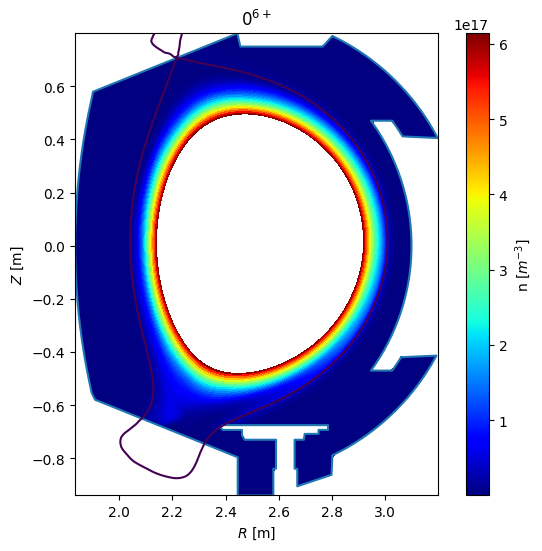

In [34]:
# Plotting results

for species in Species_names[2:9]:
    var=species+Fields_names[1]
    Plot(var,refFileName,meshFileName,plasmaStateFile,mesh_raptorXFile,fluctuations,meshEIRENEFile,plot='on')